In [1]:
using Pkg; Pkg.activate("../."); Pkg.instantiate()
using Plots; gr()
using SparseArrays
using Statistics
using ModelingToolkit
using LinearAlgebra
using HDF5
using JLD
using Infiltrator
using Zygote
using PaddedViews
using Flux
using Flux: @epochs
using DiffEqOperators
using Tullio

  Activating environment at `~/Desktop/Jordi/Julia/odinn_toy_model/Project.toml`
Precompiling project...
  ✓ Parameters
  ✓ Debugger
  ✓ DataStructures
  ✓ SortingAlgorithms
  ✓ QuadGK
  ✓ LineSearches
  ✓ JuliaFormatter
  ✓ StatsBase
  ✓ LatinHypercubeSampling
  ✓ NLsolve
  ✓ LossFunctions
  ✓ DensityRatioEstimation
  ✓ UnicodePlots
  ✓ GPUCompiler
  ✓ LightGraphs
  ✓ AverageShiftedHistograms
  ✓ Enzyme
  ✓ VertexSafeGraphs
  ✓ Distributions
  ✓ Meshes
  ✓ Optim
  ✓ SparseDiffTools
  ✓ QuasiMonteCarlo
  ✓ DiffEqBase
  ✓ KernelDensity
  ✓ DataInterpolations
  ✓ DistributionsAD
  ✓ GeoStatsBase
  ✓ SymbolicUtils
  ✓ GlobalSensitivity
  ✓ DiffEqJump
  ✓ BoundaryValueDiffEq
  ✓ Sundials
  ✓ DiffEqNoiseProcess
  ✓ GeoArrays
  ✓ DiffEqFinancial
  ✓ Symbolics
  ✓ CUDA
  ✓ ModelingToolkit
  ✓ Plots
  ✓ ParallelStencil
  ✓ NNlibCUDA
  ✓ CartesianGrids
  ✓ ParameterizedFunctions
  ✓ OrdinaryDiffEq
  ✓ DataDrivenDiffEq
  ✓ DiffEqOperators
  ✓ Flux
  ✓ DelayDiffEq
  ✓ DiffEqCallbacks
  ✓ SteadySt

In [2]:
nx, ny = 100, 100 # Size of the grid
Δx, Δy = 1, 1
Δt = 0.01
t₁ = 1

D₀ = 1
tolnl = 1e-4
itMax = 100
damp = 0.85
dτsc   = 1.0/3.0
ϵ     = 1e-4            # small number
cfl  = max(Δx^2,Δy^2)/4.1

0.24390243902439027

In [3]:
function loss(T, θ, p)
    
    uD = θ[1]
    
    T = heatflow(T, uD, p)

    l_H = sqrt(Flux.Losses.mse(T, T₁; agg=mean))

    return l_H
end

loss (generic function with 1 method)

In [4]:
function heatflow(T, D::Real, p, tol=Inf)
   
    Δx, Δy, Δt, t₁ = p
    
    total_iter = 0
    t = 0
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            F, dτ = Heat(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end
        
        t += Δt
        
    end
    
    return T
    
end

heatflow (generic function with 2 methods)

In [5]:
function Heat(T, D, p)
   
    Δx, Δy, Δt, t₁ = p
    
    #dTdx = diff(S, dims=1) / Δx
    #dTdy = diff(S, dims=2) / Δy

    dTdx_edges = diff(T[:,2:end - 1], dims=1) / Δx
    dTdy_edges = diff(T[2:end - 1,:], dims=2) / Δy
    
    Fx = -D * dTdx_edges
    Fy = -D * dTdy_edges    
    F = .-(diff(Fx, dims=1) / Δx .+ diff(Fy, dims=2) / Δy) 

    dτ = dτsc * min( 10.0 , 1.0/(1.0/Δt + 1.0/(cfl/(ϵ + D))))
    
    return F, dτ
 
end

Heat (generic function with 1 method)

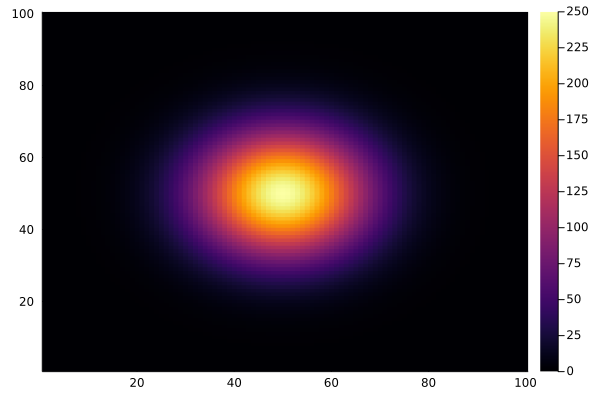

In [6]:
p = (Δx, Δy, Δt, t₁)

T₀ = [ 250 * exp( - ( (i - nx/2)^2 + (j - ny/2)^2 ) / 300 ) for i in 1:nx, j in 1:ny ]

T₁ = copy(T₀)
T₁ = heatflow(T₁, D₀, p, 1e-1)

heatmap(T₀, clim=(0, maximum(T₀)))

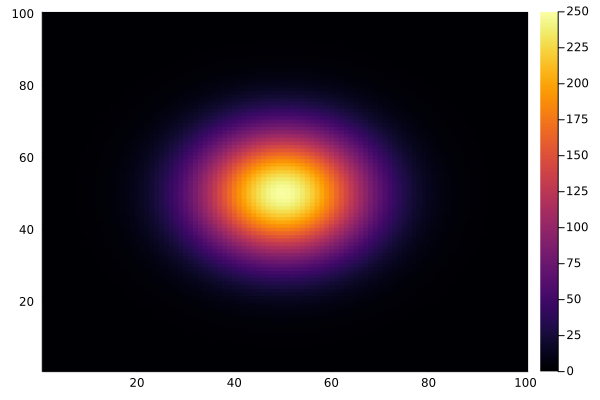

In [7]:
heatmap(T₁, clim=(0, maximum(T₀)))

In [8]:
sqrt( sum((T₁.-T₀).^2) / (nx * ny) )

0.16311579618178718

In [9]:
T = copy(T₀)

loss_uD, back_uD = Zygote.pullback(D -> loss(T, [D], p), 100)

(2.9749888654073713, Zygote.var"#46#47"{typeof(∂(#20))}(∂(#20)))

In [10]:
#all_D = 10 .^ LinRange(-4, 5, 100)
all_D = LinRange(D₀/2, 2D₀, 100)
all_loss = zeros(0)
all_grad = zeros(0)

for d in all_D
    
    T = T₀
    loss_uD, back_uD = Zygote.pullback(D -> loss(T, D, p), d)
    
    # println(d)
    # println(loss_uD, back_uD(1))
    
    append!(all_loss, loss_uD)
    append!(all_grad, back_uD(1)[1])
end

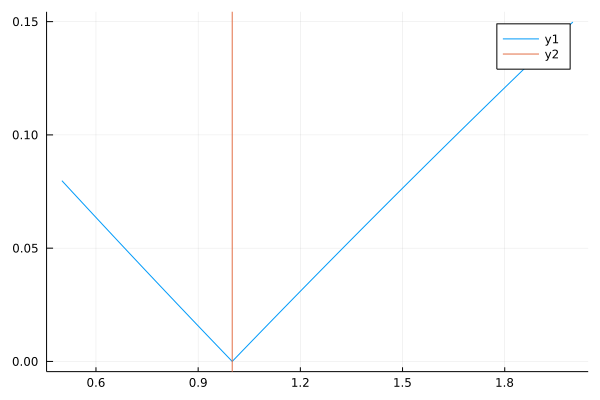

In [11]:
plot(all_D, all_loss)
vline!([D₀])

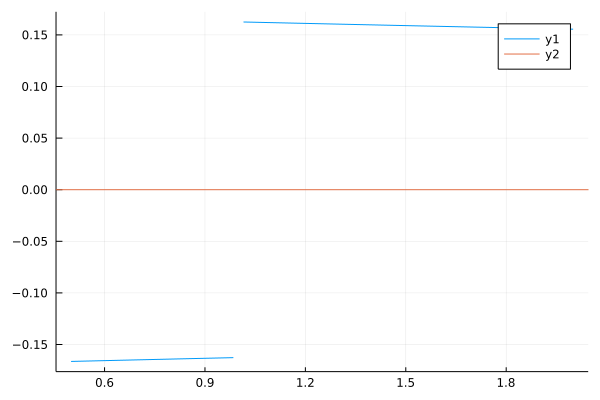

In [12]:
plot(all_D, all_grad)
hline!([0])

### Optimization on D

In [13]:
#Flux.Optimise.update!(opt, x::AbstractMatrix, Δ::AbstractVector) = Flux.Optimise.update!(opt, x, reshape(Δ, size(x)))

In [14]:
function train(loss, p)
    
    θ = [10.]

    opt = ADAM(0.1)
    @epochs 100 hybrid_train!(loss, θ, p, opt)
    
    return θ
    
end

function hybrid_train!(loss, θ, p, opt)
        
    T = T₀
    loss_uD, back_uD = Zygote.pullback(θ -> loss(T, θ, p), θ)
    
    ∇_uD = back_uD(one(loss_uD))[1]
    
    println("Loss: ", loss_uD)
    println("Current parameter: ", θ)
    println("Gradient: ", ∇_uD)
    println("opt: ", opt)
    
    Flux.Optimise.update!(opt, θ, ∇_uD)
    
end

hybrid_train! (generic function with 1 method)

In [15]:
θ₁ = train(loss, p)
D = θ₁[1]

┌ Info: Epoch 1
└ @ Main /Users/Bolib001/.julia/packages/Flux/0c9kI/src/optimise/train.jl:135


Loss: 1.0174505165728547
Current parameter: [10.0]
Gradient: [0.11536990922261617]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}())


LoadError: setindex! not defined for Zygote.OneElement{Float64, 1, Tuple{Int64}, Tuple{Base.OneTo{Int64}}}

In [ ]:
D

1.0080732395002612

## Example with NN

Let's assume that $D$ is a function of time

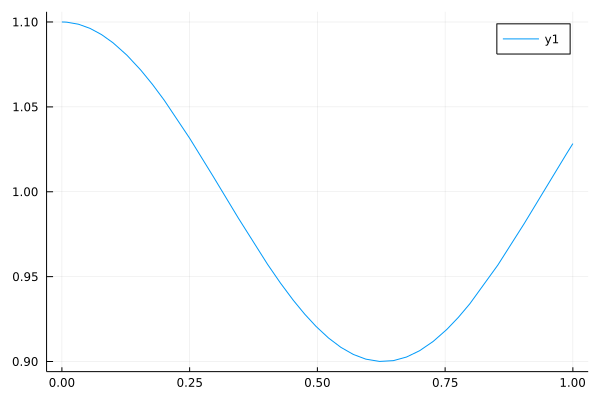

In [16]:
fakeD(t) = D₀ * (1 + 0.1 * cos(5t) )

plot(fakeD, 0, t₁)

In [17]:
function heatflow(T, fD::Function, p, tol=Inf)
   
    Δx, Δy, Δt, t₁ = p
    
    total_iter = 0
    t = 0
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            D = fD(t)  # compute the diffusivity at each time
            F, dτ = Heat(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end
        
        t += Δt
        
    end
    
    return T
    
end

heatflow (generic function with 4 methods)

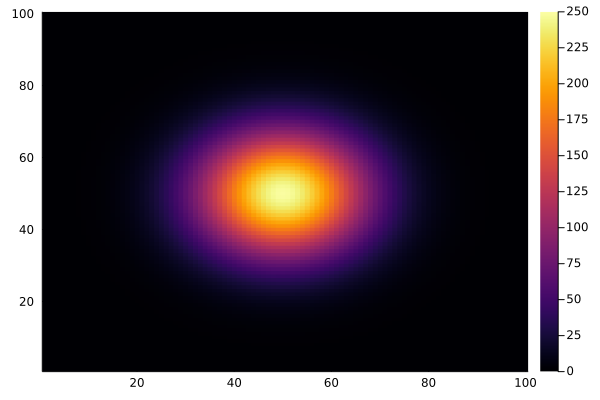

In [18]:
p = (Δx, Δy, Δt, t₁)

T₂ = copy(T₀)
T₂ = heatflow(T₂, fakeD, p, 1e-1)

heatmap(T₂, clim=(0, maximum(T₀)))

In [19]:
sqrt( sum((T₂.-T₀).^2) / (nx * ny) )

0.16014718009460116

Now, let's try to reproduce `fakeD()` with a NN.

In [20]:
function heatflow_NN(T, uD, p, tol=Inf)
   
    Δx, Δy, Δt, t₁ = p
    
    total_iter = 0
    t = 0
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            D = uD([t]')[1]  # compute the diffusivity at each time
            F, dτ = Heat(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end
        
        t += Δt
        
    end
    
    return T
    
end

heatflow_NN (generic function with 2 methods)

In [21]:
function loss_NN(T, UD, p)

    T = heatflow_NN(T, UD, p)
    l_H = sqrt(Flux.Losses.mse(T, T₂; agg=mean))

    return l_H
end

loss_NN (generic function with 1 method)

In [33]:
Flux.Optimise.update!(opt, x::AbstractMatrix, Δ::AbstractVector) = Flux.Optimise.update!(opt, x, reshape(Δ, size(x)))

function train(loss, p)
    
    leakyrelu(x, a=0.01) = max(a*x, x)
    relu(x) = max(0, x)

    UD = Chain(
        Dense(1,10,initb = Flux.zeros), 
        BatchNorm(10, leakyrelu),
        Dense(10,5,initb = Flux.zeros), 
        BatchNorm(5, leakyrelu),
        Dense(5,1, relu, initb = Flux.zeros) 
    )
    
    opt = ADAM(1.)
    losses = []
    @epochs 5 hybrid_train_NN!(loss, UD, p, opt, losses)
    
    return UD, losses
    
end

function hybrid_train_NN!(loss, UD, p, opt, losses)
    
    T = T₀
    θ = Flux.params(UD)
    loss_uD, back_uD = Zygote.pullback(() -> loss(T, UD, p), θ)
    push!(losses, loss_uD)
    
    # println("Current parameter:", θ)
    ∇_uD = back_uD(one(loss_uD))

    # for p in θ
    #     println("Gradients ∇_uD[p]: ", ∇_uD[p])
    # end
    
    Flux.Optimise.update!(opt, θ, ∇_uD)
    
end

hybrid_train_NN! (generic function with 1 method)

In [34]:
UD, losses = train(loss_NN, p)

┌ Info: Epoch 1
└ @ Main /Users/Bolib001/.julia/packages/Flux/0c9kI/src/optimise/train.jl:135


Current parameter:Params([Float32[0.58521074; 0.3062819; 0.54366434; -0.7197895; 0.6909419; 0.6578534; -0.117508106; -0.6792233; 0.6845699; -0.70371073], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Float32[0.019584194 0.20769064 -0.13764592 -0.13214271 0.049001046 -0.46150857 0.31058192 -0.18609175 0.056360763 -0.024805719; 0.22316839 -0.16201812 0.12546456 0.44026512 0.5284736 -0.57273096 -0.39506635 -0.43866357 -0.5617024 0.50851107; 0.5508643 0.1333255 -0.05904164 0.44558465 -0.42757303 0.30892473 -0.48585486 0.16561851 -0.25244847 -0.06693138; 0.0068263756 -0.56415033 0.53347665 -0.4599562 0.1256728 0.45102888 0.37874374 0.4553736 -0.14836039 0.50725; -0.09914507 -0.18892433 0.4588749 -0.20289977 -0.44452187 0.6060074 0.30060706 -0.12067746 -0.51632845 0.27985698], Float32[0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1

┌ Info: Epoch 2
└ @ Main /Users/Bolib001/.julia/packages/Flux/0c9kI/src/optimise/train.jl:135


Current parameter:Params([Float32[0.58521074; 0.3062819; 0.54366434; -0.7197895; 0.6909419; 0.6578534; -0.117508106; -0.6792233; 0.6845699; -0.70371073], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Float32[0.019584194 0.20769064 -0.13764592 -0.13214271 0.049001046 -0.46150857 0.31058192 -0.18609175 0.056360763 -0.024805719; 0.22316839 -0.16201812 0.12546456 0.44026512 0.5284736 -0.57273096 -0.39506635 -0.43866357 -0.5617024 0.50851107; 0.5508643 0.1333255 -0.05904164 0.44558465 -0.42757303 0.30892473 -0.48585486 0.16561851 -0.25244847 -0.06693138; 0.0068263756 -0.56415033 0.53347665 -0.4599562 0.1256728 0.45102888 0.37874374 0.4553736 -0.14836039 0.50725; -0.09914507 -0.18892433 0.4588749 -0.20289977 -0.44452187 0.6060074 0.30060706 -0.12067746 -0.51632845 0.27985698], Float32[0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.99999994, -0.9999999, -0.99999994, -0.9999

┌ Info: Epoch 3
└ @ Main /Users/Bolib001/.julia/packages/Flux/0c9kI/src/optimise/train.jl:135


Current parameter:Params([Float32[0.58521074; 0.3062819; 0.54366434; -0.7197895; 0.6909419; 0.6578534; -0.117508106; -0.6792233; 0.6845699; -0.70371073], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Float32[0.019584194 0.20769064 -0.13764592 -0.13214271 0.049001046 -0.46150857 0.31058192 -0.18609175 0.056360763 -0.024805719; 0.22316839 -0.16201812 0.12546456 0.44026512 0.5284736 -0.57273096 -0.39506635 -0.43866357 -0.5617024 0.50851107; 0.5508643 0.1333255 -0.05904164 0.44558465 -0.42757303 0.30892473 -0.48585486 0.16561851 -0.25244847 -0.06693138; 0.0068263756 -0.56415033 0.53347665 -0.4599562 0.1256728 0.45102888 0.37874374 0.4553736 -0.14836039 0.50725; -0.09914507 -0.18892433 0.4588749 -0.20289977 -0.44452187 0.6060074 0.30060706 -0.12067746 -0.51632845 0.27985698], Float32[0.0, 0.0, 0.0, 0.0, 0.0], Float32[-1.6632229, -1.6632228, -1.6632229, -1.663222

┌ Info: Epoch 4
└ @ Main /Users/Bolib001/.julia/packages/Flux/0c9kI/src/optimise/train.jl:135


Current parameter:Params([Float32[0.58521074; 0.3062819; 0.54366434; -0.7197895; 0.6909419; 0.6578534; -0.117508106; -0.6792233; 0.6845699; -0.70371073], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Float32[0.019584194 0.20769064 -0.13764592 -0.13214271 0.049001046 -0.46150857 0.31058192 -0.18609175 0.056360763 -0.024805719; 0.22316839 -0.16201812 0.12546456 0.44026512 0.5284736 -0.57273096 -0.39506635 -0.43866357 -0.5617024 0.50851107; 0.5508643 0.1333255 -0.05904164 0.44558465 -0.42757303 0.30892473 -0.48585486 0.16561851 -0.25244847 -0.06693138; 0.0068263756 -0.56415033 0.53347665 -0.4599562 0.1256728 0.45102888 0.37874374 0.4553736 -0.14836039 0.50725; -0.09914507 -0.18892433 0.4588749 -0.20289977 -0.44452187 0.6060074 0.30060706 -0.12067746 -0.51632845 0.27985698], Float32[0.0, 0.0, 0.0, 0.0, 0.0], Float32[-2.175427, -2.1805975, -2.1788628, -2.1844285

┌ Info: Epoch 5
└ @ Main /Users/Bolib001/.julia/packages/Flux/0c9kI/src/optimise/train.jl:135


Current parameter:Params([Float32[0.58521074; 0.3062819; 0.54366434; -0.7197895; 0.6909419; 0.6578534; -0.117508106; -0.6792233; 0.6845699; -0.70371073], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Float32[0.019584194 0.20769064 -0.13764592 -0.13214271 0.049001046 -0.46150857 0.31058192 -0.18609175 0.056360763 -0.024805719; 0.22316839 -0.16201812 0.12546456 0.44026512 0.5284736 -0.57273096 -0.39506635 -0.43866357 -0.5617024 0.50851107; 0.5508643 0.1333255 -0.05904164 0.44558465 -0.42757303 0.30892473 -0.48585486 0.16561851 -0.25244847 -0.06693138; 0.0068263756 -0.56415033 0.53347665 -0.4599562 0.1256728 0.45102888 0.37874374 0.4553736 -0.14836039 0.50725; -0.09914507 -0.18892433 0.4588749 -0.20289977 -0.44452187 0.6060074 0.30060706 -0.12067746 -0.51632845 0.27985698], Float32[0.0, 0.0, 0.0, 0.0, 0.0], Float32[-2.5949934, -2.6043994, -2.6012437, -2.611368

Chain(Dense(1, 10), BatchNorm(10, leakyrelu), Dense(10, 5), BatchNorm(5, leakyrelu), Dense(5, 1, relu))